# Introduction
In this notebook, I try to understand the data quality of Sprocket Central Pty Ltd. This is task 1 of 3 as part of KPMG Virtual Internship in Data Analytics.

#### Goal:

The goal in this notebook is to identify data quality issues and come up with strategies to mitigate them. A 'Data Quality Framework' table has been provided as resources to be referred to. 

#### Objective: 
Our objective is to identify which of the new 1000 customers, Sprocket Central Pty Ltd should target. 

We have been provided with the following datasets:
1. Customer Demographic
2. Customer Addresses
3. Transaction data in the past three months
4. New customer List

The first three datasets are that of current consumer group. We use these for data exploration and model development. Once we shortlist a model, we validate it on our test set- New Customer list. 

We view it as a clustering task as it is unsupervised learning as data is unlabeled. We group customers with similar features together and create classes of customers based on their purchasing activity. Basically, we perform customer segmentation.

We define the workflow as follow:
1. Data cleaning and formatting
2. Exploratory Data Analysis
3. Develop models and shortlist 
4. Perform Hyperparameter tuning on best model
5. Evaluate the best model on test set
6. Interpret the model
7. Draw conclusions and document results

We concentrate on the first two tasks in this notebook

## Import necessary Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('ggplot')
sns.set_style('ticks')
from matplotlib import rcParams
rcParams['figure.figsize']= 10,5

pd.set_option('display.max_columns',60)

In [2]:
file_path = os.getcwd()+'/KPMG_VI_New_raw_data_update_final.xlsx'

In [3]:
sprocket_transactions = pd.read_excel(file_path, sheet_name = 'Transactions',
                                       skiprows= 1, index_col ='transaction_id')

In [4]:
sprocket_customer_demographic = pd.read_excel(file_path, sheet_name = 'CustomerDemographic',
                                       skiprows= 1, index_col ='customer_id')

In [5]:
sprocket_customer_address = pd.read_excel(file_path, sheet_name = 'CustomerAddress',
                                       skiprows= 1, index_col ='customer_id')


# Transaction Data
## Understanding Transaction Data

In [6]:
sprocket_transactions.head()

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
transaction_id,,,,,,,,,,,,
1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10


In [7]:
sprocket_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   product_id               20000 non-null  int64         
 1   customer_id              20000 non-null  int64         
 2   transaction_date         20000 non-null  datetime64[ns]
 3   online_order             19640 non-null  float64       
 4   order_status             20000 non-null  object        
 5   brand                    19803 non-null  object        
 6   product_line             19803 non-null  object        
 7   product_class            19803 non-null  object        
 8   product_size             19803 non-null  object        
 9   list_price               20000 non-null  float64       
 10  standard_cost            19803 non-null  float64       
 11  product_first_sold_date  19803 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3)

There are some variables with missing values. First, let's understand the given data. We seprate data into numerical and categorical features for easier plotting.

In [8]:
sprocket_transactions_cat= sprocket_transactions.select_dtypes( include= 'object')
sprocket_transactions_num = sprocket_transactions.select_dtypes(include= ['float64', 'int64'])

In [9]:
sprocket_transactions_num

,product_id,customer_id,online_order,list_price,standard_cost
transaction_id,,,,,
1,2,2950,0.0,71.49,53.62
2,3,3120,1.0,2091.47,388.92
3,37,402,0.0,1793.43,248.82
4,88,3135,0.0,1198.46,381.10
5,78,787,1.0,1765.30,709.48
...,...,...,...,...,...
19996,51,1018,1.0,2005.66,1203.40
19997,41,127,1.0,416.98,312.74
19998,87,2284,1.0,1636.90,44.71


In [10]:
sprocket_transactions.describe()

,product_id,customer_id,online_order,list_price,standard_cost
count,20000.00000,20000.000000,19640.000000,20000.000000,19803.000000
mean,45.36465,1738.246050,0.500458,1107.829449,556.046951
std,30.75359,1011.951046,0.500013,582.825242,405.955660
min,0.00000,1.000000,0.000000,12.010000,7.210000
25%,18.00000,857.750000,0.000000,575.270000,215.140000
50%,44.00000,1736.000000,1.000000,1163.890000,507.580000
75%,72.00000,2613.000000,1.000000,1635.300000,795.100000
max,100.00000,5034.000000,1.000000,2091.470000,1759.850000


From the table above, we can note the following:
1. The number of people ordering online and buying in the shop are almost in same proportions. There seems to be no particular preference. However, we can see if the amount of spending varies.
2. There are two prices given: one, list_price and the other, standard_cost. The difference should give us profit. We can create a new column with profit margin for our analysis. 

Let's plot boxplots to see their spread.

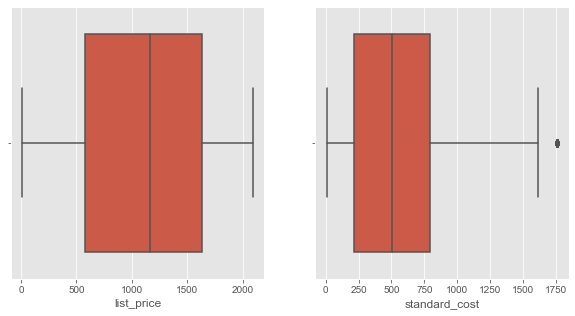

In [11]:
plt.style.use('ggplot')
fig, (ax1,ax2) = plt.subplots(1,2, sharex= False, figsize=(10,5))
sns.boxplot(sprocket_transactions['list_price'], ax= ax1)
sns.boxplot(sprocket_transactions['standard_cost'], ax= ax2)

standars_cost seems to be skewed to the right and one point as outlier. Let's inspect the item costing more than 1750. 

In [12]:
sprocket_transactions[sprocket_transactions['standard_cost']>1750]

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
transaction_id,,,,,,,,,,,,
60,60,3473,2017-12-18,0.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2014-07-28
143,60,2135,2017-01-26,1.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2012-05-18
292,64,3380,2017-10-28,0.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2015-06-17
413,60,720,2017-09-09,0.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2014-07-28
699,60,1535,2017-08-13,0.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2011-08-24
...,...,...,...,...,...,...,...,...,...,...,...,...
19191,60,3411,2017-06-23,0.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2010-08-20
19552,64,844,2017-08-09,0.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2011-08-24
19706,60,54,2017-10-24,0.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,2015-06-17


So, there are 195 transactions made where standard_cost of the item is 1759.85. However, we observe two products_id 60 and 64 for the same item as features such as brand, product_line, class and size seem to be same. We can't consider product_id to be unique.

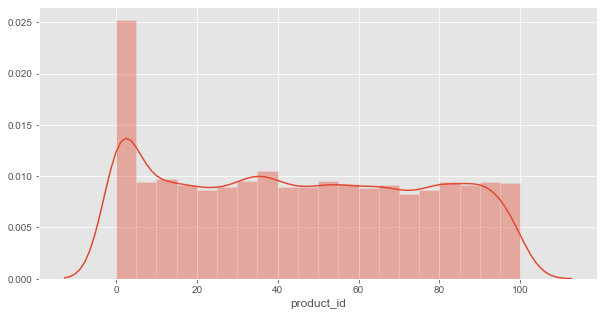

In [13]:
sns.distplot(sprocket_transactions['product_id'], bins=20)

Products with product_id 0-5 seems to be most popular. Are they the most profitable as well Let's add the profit margin column.

In [14]:
sprocket_transactions['profit_margin'] = ((sprocket_transactions['list_price']- 
                                          sprocket_transactions['standard_cost'])*
                                          100)/sprocket_transactions['standard_cost']

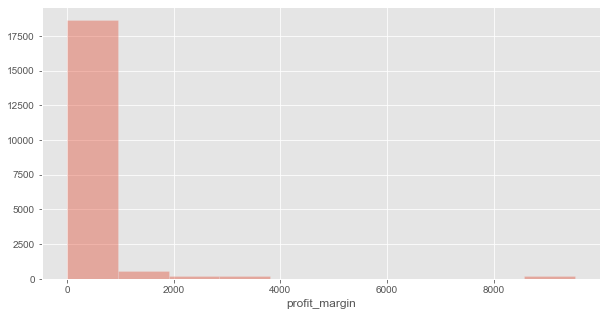

In [15]:
sns.distplot(sprocket_transactions['profit_margin'], bins=10, kde=False)

It is very interesting to note that the profit margin axis shows very high percentage of margin. Let's look at the extreme outlier first where profit margin is above 8000% . 

In [16]:
sprocket_transactions[sprocket_transactions['profit_margin']>8000]

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,profit_margin
transaction_id,,,,,,,,,,,,,
8,15,2459,2017-07-15,0.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238
19,54,2268,2017-04-06,1.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238
71,54,419,2017-01-03,0.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238
225,54,2036,2017-03-30,1.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238
361,15,2589,2017-01-31,0.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19337,54,3029,2017-08-31,0.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238
19387,15,1863,2017-03-26,1.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238
19397,15,430,2017-06-25,0.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12,9519.345238


There are two things to be noted. 
1. It is almost impossible to price bicycle products at 8000% margin. There must be some error at recording the standard_cost amount. 
2. We observe two product ids representing the same item as we have also noted earlier.

Let's look at items with 2000-4000% profit margin.

In [17]:
check = sprocket_transactions[(sprocket_transactions['profit_margin']>2000)&(sprocket_transactions['profit_margin']<4000)]
check.head(15)

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,profit_margin
transaction_id,,,,,,,,,,,,,
25,89,2822,2017-06-11,0.0,Approved,WeareA2B,Touring,medium,large,1362.99,57.74,1993-04-20,2260.564600
105,89,821,2017-10-26,0.0,Approved,WeareA2B,Touring,medium,large,1362.99,57.74,2013-06-09,2260.564600
149,89,788,2017-03-21,0.0,Approved,WeareA2B,Touring,medium,large,1362.99,57.74,1993-04-20,2260.564600
268,68,1516,2017-08-27,0.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,2010-08-20,3561.149631
309,68,3394,2017-11-27,0.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,2010-08-20,3561.149631
324,87,2049,2017-10-11,0.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,2010-08-20,3561.149631
375,17,3276,2017-07-05,1.0,Approved,WeareA2B,Touring,medium,large,1362.99,57.74,1993-04-20,2260.564600
485,87,804,2017-03-17,0.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,2002-08-31,3561.149631
503,87,2468,2017-08-07,1.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,2010-08-20,3561.149631


In [18]:
check['product_id'].value_counts()

68    146
89    145
87     52
17     52
Name: product_id, dtype: int64

In [19]:
sprocket_transactions[sprocket_transactions['profit_margin']>100].shape

(6704, 13)

There are four different products whichin the 2000-4000 profit margin range of which items with product_id 68 and 87 seems to be same.Also, the standard cost listed could be misrepresenting the actual amount. There are 6704 items out of 20,000 that have more than 100% in margin. I believe that a bicycle can have a markup of atmost 50%. But more than 100 seems a little improbable.  
So, the ideal method would be asking the client for correct values and more information on recording procedure. For now, we drop the columns product_id and standard_cost from our analysis.

In [20]:
col_drop = ['product_id', 'standard_cost', 'profit_margin']
sprocket_transactions_new = sprocket_transactions.drop(col_drop, axis=1)

In [80]:
now = pd.Timestamp('now')
sprocket_transactions['recency'] = (now- sprocket_transactions['transaction_date'])/np.timedelta64(1,'D')

In [89]:
recency = sprocket_transactions[['recency','customer_id']].groupby('customer_id')['recency'].min()

In [76]:
sprocket_transactions_new.sort_values(by='list_price', ascending= False)

,customer_id,online_order,order_status,brand,product_line,list_price
transaction_id,,,,,,
995,1558,0.0,Approved,Trek Bicycles,Standard,2091.47
2598,2506,1.0,Approved,Trek Bicycles,Standard,2091.47
10582,2341,0.0,Approved,Trek Bicycles,Standard,2091.47
8666,1392,1.0,Approved,Trek Bicycles,Standard,2091.47
12629,902,1.0,Approved,Trek Bicycles,Standard,2091.47
...,...,...,...,...,...,...
17772,1047,0.0,Approved,OHM Cycles,Road,12.01
17077,3196,1.0,Approved,OHM Cycles,Road,12.01
8903,1536,1.0,Approved,OHM Cycles,Road,12.01


Let's observe each of the features in relation with the list_price
1. Are there customers who buy more than the others? Who are they and what do they buy?
2. Are there days where there is more spending? such as weekends?
3. Do people spend more online or offline?
4. When an order is cancelled, what kind of items are they? Is there is a specific item/issue?
5. what brand of cycles are sold most? Which of them is most expensive?
6. Which product_line is expensive? Which product_class/size?
7. What can we make of the product_first_sold_date?
8. Look into category-category relationships.


#### Relationship between Customer_id and list_price
Let's create a table with Customer id and total purchase amounts in descending order. 

In [22]:
sprocket_transactions_past3months = sprocket_transactions_new.groupby(['customer_id']).sum().sort_values(by= 'list_price', ascending= False)
sprocket_transactions_past3months['price_per_online_order']= sprocket_transactions_past3months['list_price']/sprocket_transactions_past3months['online_order']
sprocket_transactions_past3months= sprocket_transactions_past3months.replace(np.inf,0)
sprocket_transactions_past3months

,online_order,list_price,price_per_online_order
customer_id,,,
2183,4.0,19071.32,4767.830000
1129,8.0,18349.27,2293.658750
1597,6.0,18052.68,3008.780000
941,6.0,17898.46,2983.076667
2788,6.0,17258.94,2876.490000
...,...,...,...
2423,0.0,202.62,0.000000
3189,2.0,200.70,100.350000
2274,2.0,142.98,71.490000


We observe 3494 unique customer ids whose total purchases and number of online purchases have been listed. Let's plot the distribution of total purchases by the customers.

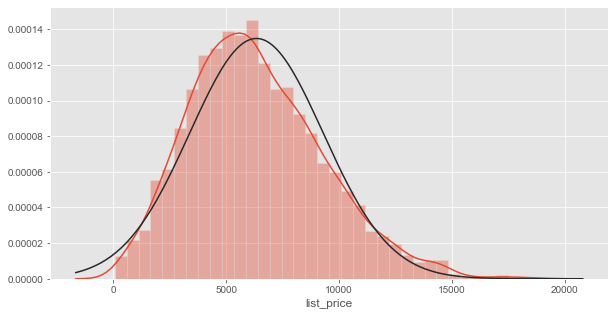

In [23]:
from scipy.stats import norm
sns.distplot(sprocket_transactions_past3months['list_price'], fit=norm)

An average customer spent 5000$ in the past three months on bicycles and bicycle accessories. The distribution is close to normal and not highly skewed.

Do the customers who spend more also spend more time shopping online?

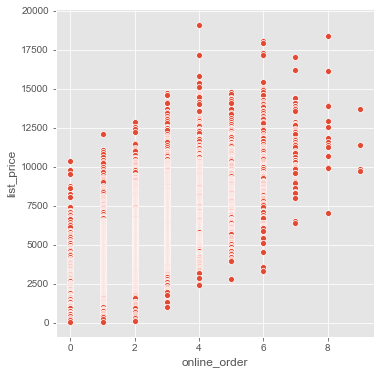

In [24]:
sns.pairplot( x_vars = 'online_order', y_vars = 'list_price',data= sprocket_transactions_past3months, height=5)

Yes, there is a general upward trend. But does that translate to higher ticket items purchased by online-savvy customers? Our plot below shows that it is not the case. While customers who order online a lot, in general, spend a higher minimum amount than the others but don't spend a lot more per order than the lower frequency online shoppers. 

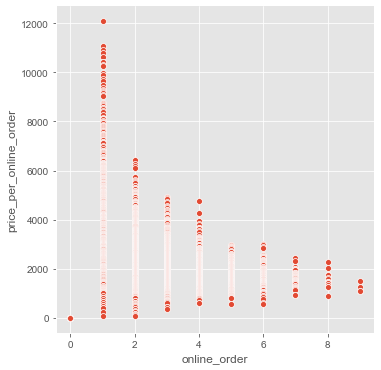

In [25]:
sns.pairplot( x_vars = 'online_order', y_vars = 'price_per_online_order', data= sprocket_transactions_past3months, height=5)

Let's see if there is more activity on weekends than weekdays and if customers spend more on weekends.

In [26]:
sprocket_transactions_new['day_of_week']= sprocket_transactions_new['transaction_date'].dt.dayofweek

In [27]:
sprocket_transactions_new.groupby('day_of_week').sum()

,customer_id,online_order,list_price
day_of_week,,,
0,4948378,1439.0,3161300.17
1,4950575,1388.0,3151170.38
2,5020349,1402.0,3259954.33
3,4929493,1436.0,3115125.28
4,4963223,1360.0,3086922.48
5,4907659,1394.0,3198700.42
6,5045244,1410.0,3183415.92


Text(0.5, 1.0, 'Customer Spending')

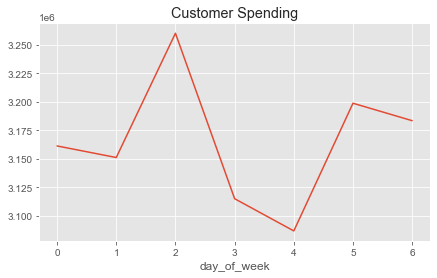

In [28]:
# day of the week vs spending
sprocket_transactions_new.groupby('day_of_week')['list_price'].sum().plot(figsize=(7,4))
plt.title('Customer Spending')

Text(0.5, 1.0, 'Customer Footfall')

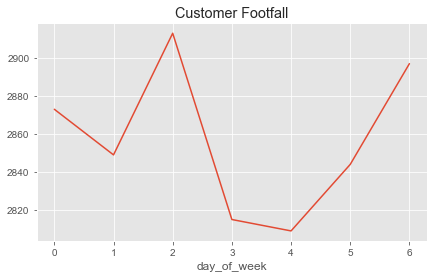

In [29]:
# day of the week vs footfall of unique customers
sprocket_transactions_new.groupby('day_of_week')['customer_id'].count().plot(figsize=(7,4))
plt.title('Customer Footfall')

Monday = 0, Sunday =6

Contrary to the assumption that there is more activity on the weekend, we find that Wednesday is the busiest day for Sprocket Central , atleast in the past three months. Thursdays and Fridays are least busy. Although there is increase in footfall from Saturday to Sunday, the consumer spending really doesn't. 

Let's see how the transaction activity, both offline and online, is spread over the week.

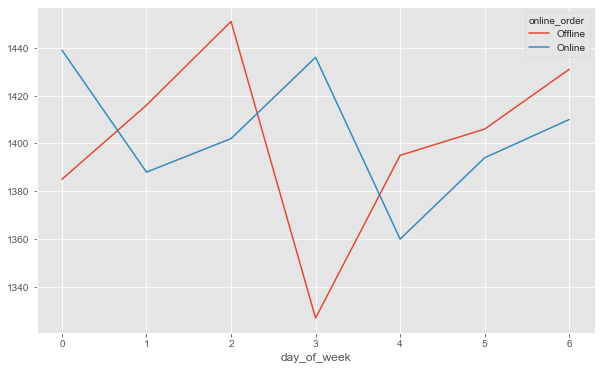

In [30]:
online_offline = pd.crosstab(index=sprocket_transactions_new['day_of_week'], 
                  columns= sprocket_transactions_new['online_order'])
online_offline_rename= online_offline.rename(columns=({0:'Offline', 1:'Online'}))
online_offline_rename.plot(figsize=(10,6))


Consumers visit the store most on Wedenesdays, followed by weekends and least on Thursday. The online store visits are little more consistent and have most activity on Mondays and Thrusdays.
### Categorical Variables

In [31]:
def count_values(df):
    
    if len(df.keys())%2 == 0:
        height = round(len(df.keys())/2)
    else:
        height = round(len(df.keys())/2)+1
    fig, axes= plt.subplots(height,2, sharex= False)
    for ax, feature in zip(fig.axes, df.keys()):
        sns.countplot(df[feature], ax= ax)

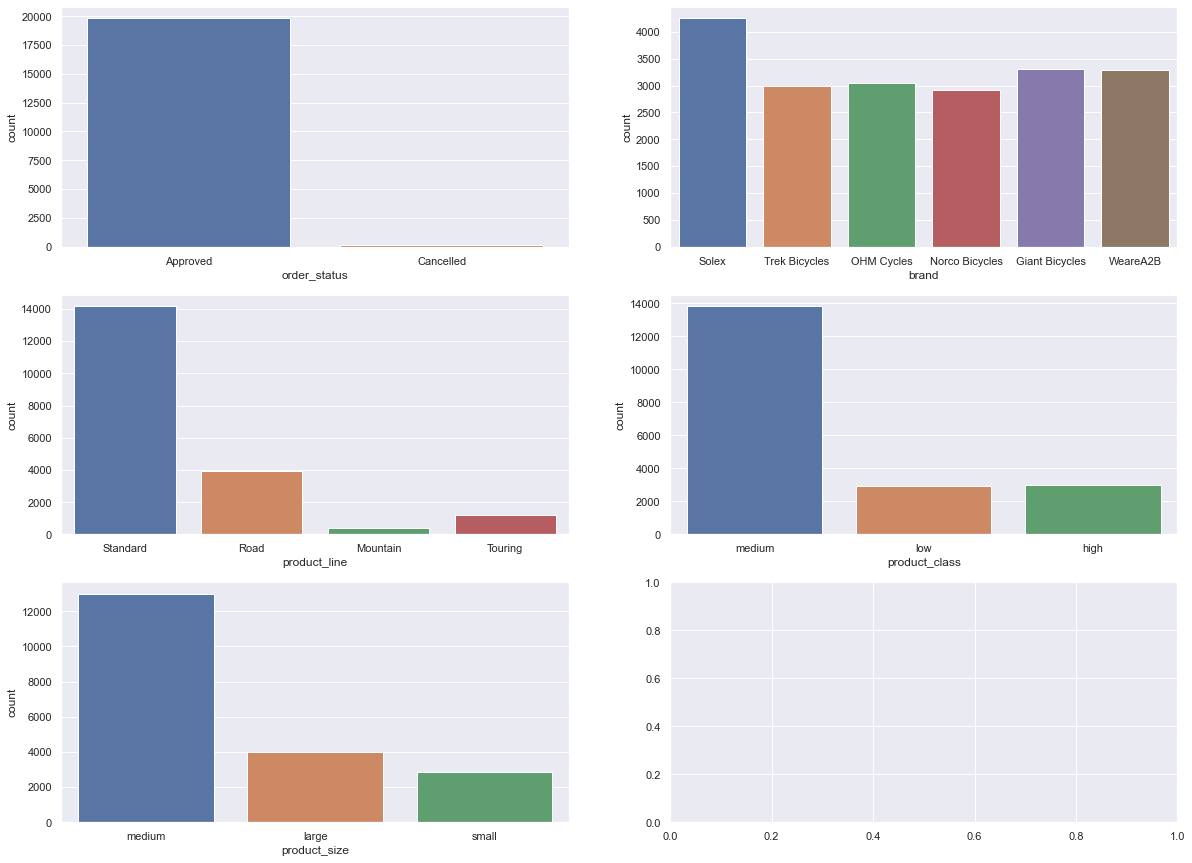

In [32]:
sns.set(rc={'figure.figsize':(20,15)})
count_values(sprocket_transactions_cat)

Solex seems to be the leading brand in terms of number of sales. The Standard product_line is most popular and mountain range least. Medium sized and medium class items are preferred over small or large and low or high respectively.Except for few cancelled orders,most of them are approved. We can find out why they have been cancelled for better understanding. In the given dataset, there are equal % of people ordering online and buying in store. There isn't a particular preference. 

Let's look at the price range for different brands of cycles.

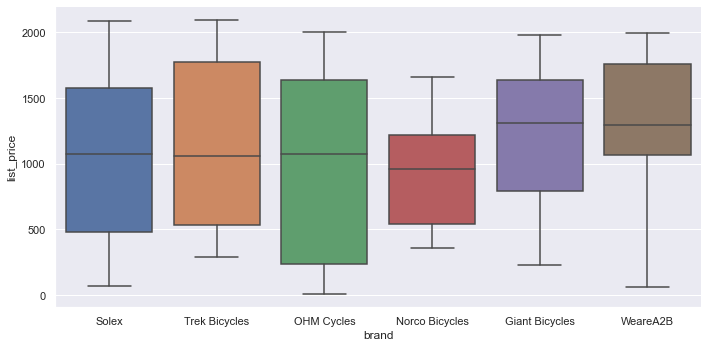

In [33]:
sns.catplot( x = 'brand', y = 'list_price', kind= 'box', data= sprocket_transactions_new, aspect=10/5)

Of the brands, Giant Bicycles and WeareA2B have higher mean list prices than rest of the brands. Is it because they dominate in different product lines?

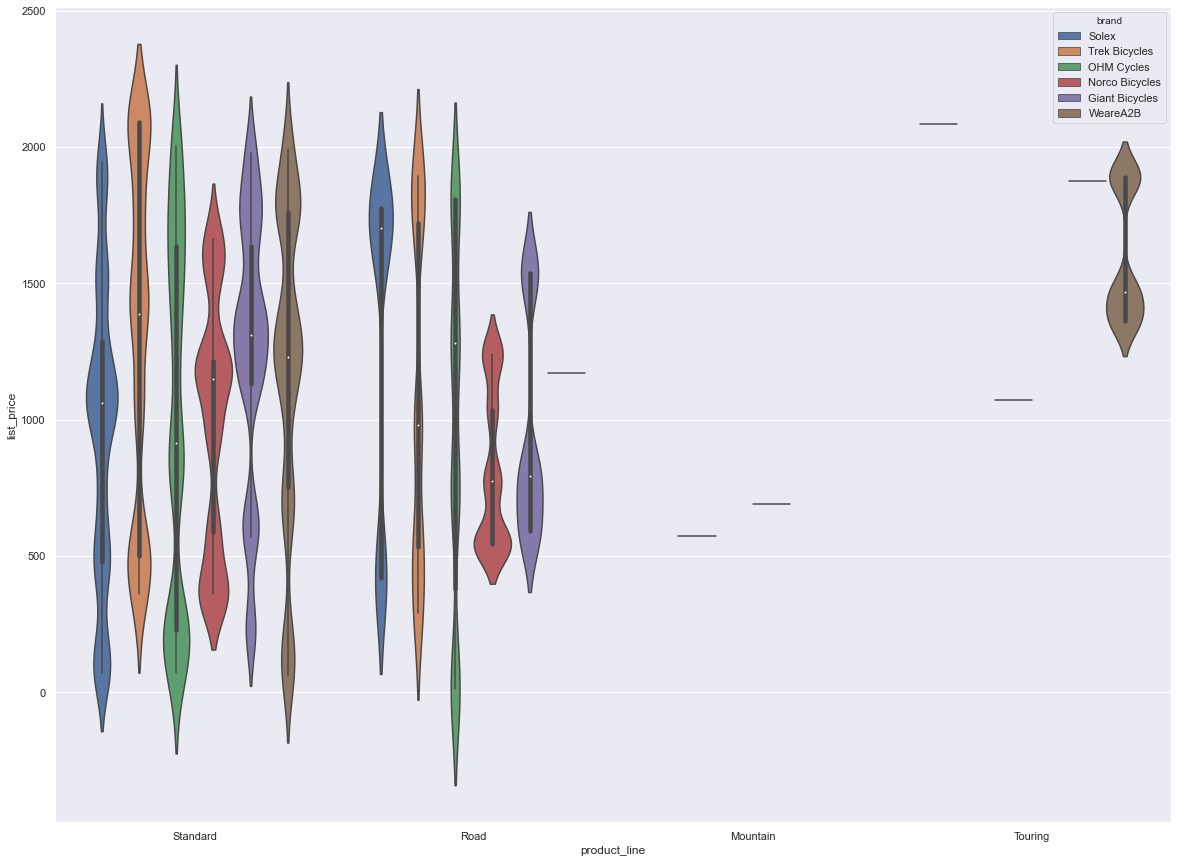

In [34]:
sns.violinplot( x = 'product_line', y = 'list_price', hue='brand', data= sprocket_transactions_new)

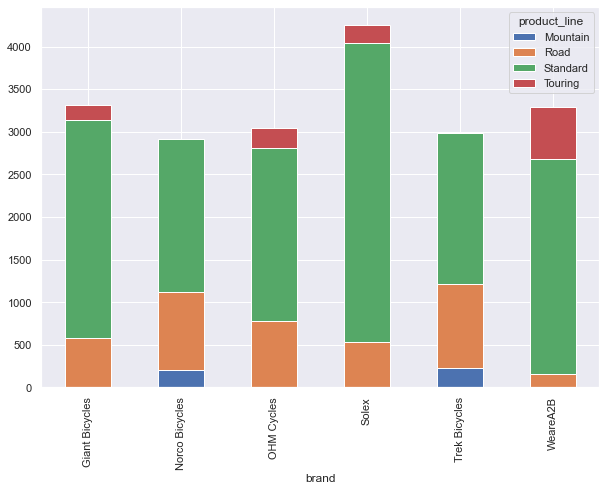

In [35]:
brand_product_line = pd.crosstab(index=sprocket_transactions['brand'], 
                  columns= sprocket_transactions['product_line'])
brand_product_line.plot(kind='bar', stacked= True, figsize=(10,7))

Solex has dominat presence in Standard and Road bicycles pricing the latter higher than the rest of competition. Trek Bicycles and Norco Bicycles are popular choices for road product line. They are the only choices for mountain product line with Norco pricing its products a little higher. WeareA2B is the most dominant seller of Touring bikes.

Does a certain product_line command a higher price? Standard and road bike items are available in all price ranges. While mountain bike product line items are in the range of 500-700$, the starting price of touring bikes is upwards of 1000. 

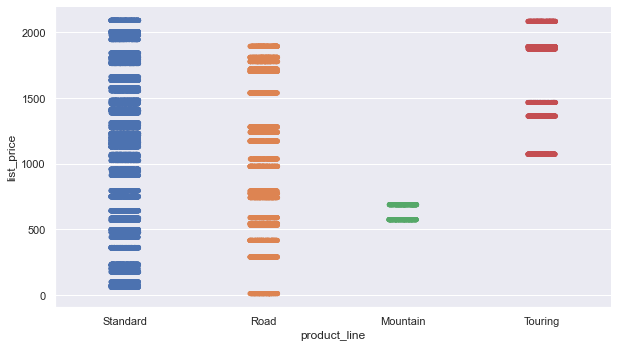

In [36]:
sns.catplot( x = 'product_line', y = 'list_price', data= sprocket_transactions_new, aspect=7/4)

Are product_class and product_size related?

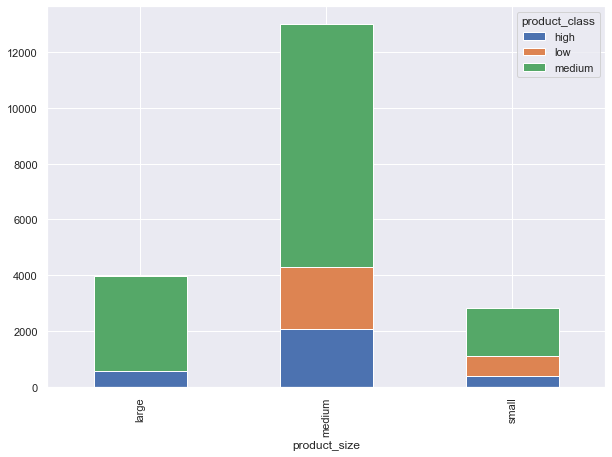

In [37]:
brand_product_line = pd.crosstab(index=sprocket_transactions['product_size'], 
                  columns= sprocket_transactions['product_class'])
brand_product_line.plot(kind='bar', stacked= True, figsize=(10,7))

Most of the products are categorized under medium size. And most products are 'medium class'. However, we need more data to interpret them.

Do certain brands/ product lines belong to a certain class?

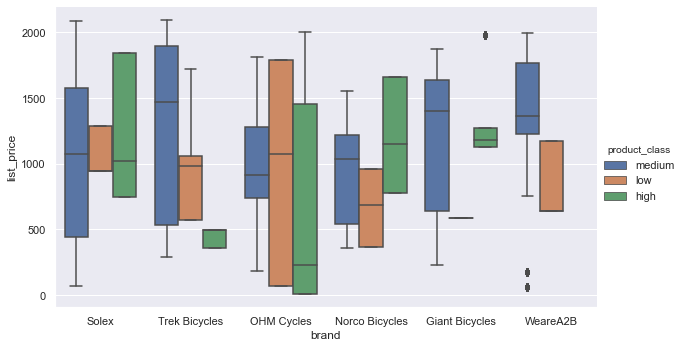

In [38]:
sns.catplot(x= 'brand', y='list_price',kind='box', hue='product_class', data= sprocket_transactions_new, aspect=12/7)

I find it a bit puzzling to see product class categorized as low or medium priced higher than medium and high classes respectively. However, WeareA2B has no products in high class and Giant Bicycles has very few products in low class. 

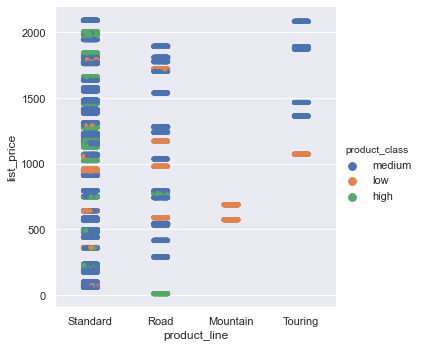

In [39]:
sns.catplot( x = 'product_line', y = 'list_price', hue='product_class', data= sprocket_transactions_new)

From the above plot, we can infer that mountain bicycles have been classfies as low product class. Few products of touring bicycles have been categorized as low and the rest as medium class. The bicycles of Standard product line has the highest number of high class bicycles. 

However,we need for information regardging the product_class and product_size on their categorization before we can make any valuable inferences.

In [40]:
sprocket_transactions_cancelled= sprocket_transactions_new[sprocket_transactions_new['order_status']=='Cancelled']
sprocket_transactions_cancelled

,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,product_first_sold_date,day_of_week
transaction_id,,,,,,,,,,,
43,488,2017-03-17,0.0,Cancelled,WeareA2B,Standard,low,medium,642.31,2014-10-10,4
139,2073,2017-03-25,0.0,Cancelled,Giant Bicycles,Standard,high,medium,1179.00,2000-11-03,5
250,1454,2017-11-25,0.0,Cancelled,WeareA2B,Standard,medium,medium,1762.96,1997-02-09,5
255,2801,2017-04-01,1.0,Cancelled,Norco Bicycles,Road,medium,medium,544.05,2005-10-22,5
584,1019,2017-09-13,1.0,Cancelled,Solex,Standard,medium,medium,1151.96,1993-04-12,2
...,...,...,...,...,...,...,...,...,...,...,...
19406,1860,2017-05-29,0.0,Cancelled,Norco Bicycles,Standard,medium,medium,1555.58,2015-08-02,0
19410,1771,2017-01-15,0.0,Cancelled,Norco Bicycles,Standard,medium,medium,1555.58,2015-08-10,6
19823,2312,2017-12-02,0.0,Cancelled,Trek Bicycles,Standard,medium,large,2091.47,1999-07-20,5


In [41]:
sprocket_transactions_cancelled.groupby('product_line').sum()

,customer_id,online_order,list_price,day_of_week
product_line,,,,
Mountain,7697,2.0,1951.90,12
Road,64013,25.0,39024.78,118
Standard,219316,67.0,146225.10,375
Touring,13112,3.0,14984.67,27


In [42]:
sprocket_transactions_cancelled.groupby('brand').sum()

,customer_id,online_order,list_price,day_of_week
brand,,,,
Giant Bicycles,45745,13.0,36055.61,102
Norco Bicycles,47996,12.0,24481.68,90
OHM Cycles,46743,17.0,27960.55,71
Solex,76344,26.0,49689.28,111
Trek Bicycles,40488,21.0,27288.55,68
WeareA2B,46822,8.0,36710.78,90


Nothing seems to standout, a certain % of products seem to be cancelled. If we have more information, we can figure out further. 

In [43]:
sprocket_transactions_new.shape

(20000, 11)

## Dealing with missing Values
We have data of 20,000 transactions and 11 features. Except for list_price, most of the other variables are categorical in nature. There are few variables with missing values. 

In [44]:
def missing_values_table(df):
    """
    input  : dataframe for which you want to calculate missing values - df
    output : table listing columns, missing value count and percentages
    """
    missing_val = df.isnull().sum() # missing values per column
    missing_val_percent = missing_val *100 / len(df)
    # creating a table
    missing_val_table = pd.concat([missing_val, missing_val_percent], axis=1)
    missing_val_table_rename= missing_val_table.rename(columns=
                                                       {0:'Missing Values Count'
                                                        ,1:'Missing Values %'})
    missing_val_table_sort = missing_val_table_rename[missing_val_table_rename
                                                      ['Missing Values Count']
                                                        !=0].sort_values(by=
                                                        'Missing Values Count',
                                                        ascending = False).round(1)
    
    print('Your dataframe has {} columns of which {} columns contain missing values'.
          format(df.shape[1],len(missing_val_table_sort)))
    return missing_val_table_sort
    

In [45]:
missing_values_table(sprocket_transactions_new)

Your dataframe has 11 columns of which 6 columns contain missing values


,Missing Values Count,Missing Values %
online_order,360,1.8
brand,197,1.0
product_line,197,1.0
product_class,197,1.0
product_size,197,1.0
product_first_sold_date,197,1.0


For these missing values, we have the option of imputing them or deleting rows of missing values. 

Let's create a copy of our data before we make any changes. 

In [46]:
sprocket_transactions_new_copy= sprocket_transactions_new.copy()
        

But, we haven't completely answered our first question: Are there customers who purchase more than the others? Who are they? What do they buy? We will look the Consumer Demographics and their addresses to answer that question.

We need to merge our datasets to do so. We need to be able to include information on categorical variables as well, and so we create dummy variables. I drop product_class and product_size,product_first_sold_date and transaction_date from my data. I also drop day_of_week as I no longer need it. 

In [47]:
sprocket_transactions_new = sprocket_transactions_new.drop(['product_class', 'product_size','product_first_sold_date','transaction_date','day_of_week'], axis=1)

I fill online_order with random values of 0,1 as our data has almost 50% values of each.

In [48]:
sprocket_transactions_new['online_order']=sprocket_transactions_new['online_order'].fillna(np.random.randint(2))

We are left with brand and product_line

In [49]:
from sklearn.impute import SimpleImputer
imp= SimpleImputer(missing_values= np.nan, strategy ='most_frequent')
sprocket_transactions_new[['brand','product_line']]= imp.fit_transform(sprocket_transactions_new[['brand','product_line']])

In [50]:
sprocket_transactions_transform = sprocket_transactions_new.copy()


In [51]:
sprocket_transactions_transform_dummies= pd.get_dummies(sprocket_transactions_transform)

We have the option to label encode, but we need to club the transactions unqiue to customer_id later and hence we choose to create dummy variables

In [52]:
conditions= [
    (sprocket_transactions_transform_dummies['online_order']==0),
    (sprocket_transactions_transform_dummies['online_order']==1)]
choices= [1.0,0.0]
sprocket_transactions_transform_dummies['offline_order']= np.select(conditions,choices, default=np.nan)
sprocket_transactions_transform_dummies

,customer_id,online_order,list_price,order_status_Approved,order_status_Cancelled,brand_Giant Bicycles,brand_Norco Bicycles,brand_OHM Cycles,brand_Solex,brand_Trek Bicycles,brand_WeareA2B,product_line_Mountain,product_line_Road,product_line_Standard,product_line_Touring,offline_order
transaction_id,,,,,,,,,,,,,,,,
1,2950,0.0,71.49,1,0,0,0,0,1,0,0,0,0,1,0,1.0
2,3120,1.0,2091.47,1,0,0,0,0,0,1,0,0,0,1,0,0.0
3,402,0.0,1793.43,1,0,0,0,1,0,0,0,0,0,1,0,1.0
4,3135,0.0,1198.46,1,0,0,1,0,0,0,0,0,0,1,0,1.0
5,787,1.0,1765.30,1,0,1,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,1018,1.0,2005.66,1,0,0,0,1,0,0,0,0,0,1,0,0.0
19997,127,1.0,416.98,1,0,0,0,0,1,0,0,0,1,0,0,0.0
19998,2284,1.0,1636.90,1,0,0,0,1,0,0,0,0,0,1,0,0.0


In [53]:
sprocket_transactions_transform_dummies=sprocket_transactions_transform_dummies.groupby(['customer_id']).sum()

In [78]:
sprocket_transactions_transform_dummies

,online_order,list_price,order_status_Approved,order_status_Cancelled,brand_Giant Bicycles,brand_Norco Bicycles,brand_OHM Cycles,brand_Solex,brand_Trek Bicycles,brand_WeareA2B,product_line_Mountain,product_line_Road,product_line_Standard,product_line_Touring,offline_order
customer_id,,,,,,,,,,,,,,,
1,6.0,9084.45,11,0,4,2,2,2,1,0,1,3,7,0,5.0
2,1.0,4149.07,3,0,1,0,0,0,0,2,0,0,3,0,2.0
3,2.0,9888.23,8,0,2,3,0,0,3,0,1,3,4,0,6.0
4,1.0,1047.72,2,0,1,0,0,1,0,0,0,0,2,0,1.0
5,2.0,5903.20,6,0,1,2,0,1,1,1,1,3,2,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,2.0,3744.07,3,0,2,0,0,1,0,0,0,0,3,0,1.0
3498,5.0,5177.06,6,0,0,0,1,2,1,2,0,0,5,1,1.0
3499,4.0,7673.48,7,0,2,1,0,2,0,2,0,1,5,1,3.0


In [94]:
sprocket= pd.concat([sprocket_transactions_transform_dummies,recency], axis=1)
sprocket

,online_order,list_price,order_status_Approved,order_status_Cancelled,brand_Giant Bicycles,brand_Norco Bicycles,brand_OHM Cycles,brand_Solex,brand_Trek Bicycles,brand_WeareA2B,product_line_Mountain,product_line_Road,product_line_Standard,product_line_Touring,offline_order,recency
customer_id,,,,,,,,,,,,,,,,
1,6.0,9084.45,11,0,4,2,2,2,1,0,1,3,7,0,5.0,849.582348
2,1.0,4149.07,3,0,1,0,0,0,0,2,0,0,3,0,2.0,970.582348
3,2.0,9888.23,8,0,2,3,0,0,3,0,1,3,4,0,6.0,944.582348
4,1.0,1047.72,2,0,1,0,0,1,0,0,0,0,2,0,1.0,1037.582348
5,2.0,5903.20,6,0,1,2,0,1,1,1,1,3,2,0,4.0,858.582348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,2.0,3744.07,3,0,2,0,0,1,0,0,0,0,3,0,1.0,894.582348
3498,5.0,5177.06,6,0,0,0,1,2,1,2,0,0,5,1,1.0,969.582348
3499,4.0,7673.48,7,0,2,1,0,2,0,2,0,1,5,1,3.0,893.582348


We are usign RFM (recency, frequency and Monetary value) analysis to segment customers. Customers with lowest recency, highest frequency and monetary value are considered to be top customers. 

In [96]:
rfm= sprocket[['recency','order_status_Approved','list_price']]
rfm

,recency,order_status_Approved,list_price
customer_id,,,
1,849.582348,11,9084.45
2,970.582348,3,4149.07
3,944.582348,8,9888.23
4,1037.582348,2,1047.72
5,858.582348,6,5903.20
...,...,...,...
3497,894.582348,3,3744.07
3498,969.582348,6,5177.06
3499,893.582348,7,7673.48


In [97]:
# compute quantile values of RFM values
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['order_status_Approved'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['list_price'], 4, ['4','3','2','1'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [98]:
rfm

,recency,order_status_Approved,list_price,r_quartile,f_quartile,m_quartile
customer_id,,,,,,
1,849.582348,11,9084.45,1,1,1
2,970.582348,3,4149.07,4,4,4
3,944.582348,8,9888.23,4,1,1
4,1037.582348,2,1047.72,4,4,4
5,858.582348,6,5903.20,1,3,3
...,...,...,...,...,...,...
3497,894.582348,3,3744.07,3,4,4
3498,969.582348,6,5177.06,4,3,3
3499,893.582348,7,7673.48,3,2,2


In [99]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,recency,order_status_Approved,list_price,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
1,849.582348,11,9084.45,1,1,1,111
2,970.582348,3,4149.07,4,4,4,444
3,944.582348,8,9888.23,4,1,1,411
4,1037.582348,2,1047.72,4,4,4,444
5,858.582348,6,5903.20,1,3,3,133


In [104]:
# Filter out Top/Best cusotmers
sprocket_top_customer = rfm[rfm['RFM_Score']=='111'].sort_values('list_price', ascending=False)
sprocket_top_customer.head()

,recency,order_status_Approved,list_price,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
2183,850.582348,14,19071.32,1,1,1,111
1140,848.582348,13,16199.24,1,1,1,111
729,843.582348,10,15826.00,1,1,1,111
1317,852.582348,9,15370.81,1,1,1,111
2762,858.582348,9,15071.26,1,1,1,111


In [105]:
len(sprocket_top_customer)

212

We have identified 212 top customers based on RFM analysis from our dataset. Let's incude that in our dataset.

In [115]:
conditions= [
    (rfm['RFM_Score']=='111'),
    (rfm['RFM_Score']!='111')
]
choices= [1.0,0.0]
sprocket['top_customer'] = np.select(conditions,choices, default=np.nan)

0.0    3282
1.0     212
Name: top_customer, dtype: int64

In [116]:
sprocket.to_csv('Sprocket_Transactions_customer_id.csv')

# Conclusion
In this notebook, we 